<a href="https://colab.research.google.com/github/brianna-mitri/deep-learning-challenge/blob/main/AlphabetSoupCharity_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install keras-tuner

In [2]:
#imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt

In [3]:
# read in data into df
charity_df = pd.read_csv('https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv')
charity_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


## Data Check
---

### See distribution of output variable

In [4]:
charity_df['IS_SUCCESSFUL'].value_counts()

,count
IS_SUCCESSFUL,
1,18261
0,16038


### See if ASK_AMT is skewed --> YES (try log transform instead of ONLY standard standard scaler)

In [5]:
# look at summary stats
charity_df['ASK_AMT'].describe()

,ASK_AMT
count,3.429900e+04
mean,2.769199e+06
std,8.713045e+07
min,5.000000e+03
25%,5.000000e+03
50%,5.000000e+03
75%,7.742000e+03
max,8.597806e+09


In [6]:
# show only mean versus median --> mean much > than median --> indicates right skew
print(f"Mean: {charity_df['ASK_AMT'].mean()}")
print(f"Median: {charity_df['ASK_AMT'].median()}")

Mean: 2769198.6820607013
Median: 5000.0


In [7]:
# check skewness --> right skew
charity_df['ASK_AMT'].skew()

np.float64(72.4101078515525)

### Check Status distribution

In [8]:
# check value counts --> basically always 1 (doesn't add much so should drop it)
charity_df['STATUS'].value_counts()

,count
STATUS,
1,34294
0,5


## Data Preprocessing
---

### Drop columns

In [9]:
# drop status column
charity_df = charity_df.drop(columns=['STATUS']).copy()

In [10]:
# drop id columns (EIN, NAME)
charity_df = charity_df.iloc[:, 2:].copy()
charity_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,100000-499999,N,142590,1


In [11]:
# check dtypes
charity_df.dtypes

,0
APPLICATION_TYPE,object
AFFILIATION,object
CLASSIFICATION,object
USE_CASE,object
ORGANIZATION,object
INCOME_AMT,object
SPECIAL_CONSIDERATIONS,object
ASK_AMT,int64
IS_SUCCESSFUL,int64


### Grouping smaller category levels (not ask amt becaues numeric)

In [12]:
# check number of unique columns and shape
print(charity_df.shape)
charity_df.nunique()

(34299, 9)


,0
APPLICATION_TYPE,17
AFFILIATION,6
CLASSIFICATION,71
USE_CASE,5
ORGANIZATION,4
INCOME_AMT,9
SPECIAL_CONSIDERATIONS,2
ASK_AMT,8747
IS_SUCCESSFUL,2


In [13]:
# get list of columns with more than 10 unique values
long_cols = [col for col in list(charity_df.columns) if charity_df[col].nunique() > 10]
long_cols

['APPLICATION_TYPE', 'CLASSIFICATION', 'ASK_AMT']

In [14]:
# function to replace "rare" col values with "other"
def label_other(index, cutoff_num):
  col = long_cols[index]
  cnts = charity_df[col].value_counts()
  others = cnts[cnts < cutoff_num].index

  # replace with other
  charity_df[col] = charity_df[col].replace(others, "Other")

In [15]:
# label other for value_counts() < cutoff_num
label_other(0, 500)  #app type
label_other(1, 1500)  #classification

In [16]:
# check unique count 3now
charity_df.nunique()

,0
APPLICATION_TYPE,9
AFFILIATION,6
CLASSIFICATION,6
USE_CASE,5
ORGANIZATION,4
INCOME_AMT,9
SPECIAL_CONSIDERATIONS,2
ASK_AMT,8747
IS_SUCCESSFUL,2


### Train/Test split

In [17]:
# separate target
x_vars = charity_df.iloc[:, 0:-1]
y_var = charity_df.iloc[:, -1]

In [18]:
# do train test split
x_train, x_test, y_train, y_test = train_test_split(
    x_vars,
    y_var,
    stratify=y_var,  #preserve the class ratio
    random_state=1
)

### Encode categorical variables & scale numeric

In [19]:
# avoid data leakage and identify column type (categorical/numeric) from x_train
cat_cols = x_vars.select_dtypes(include=['object']).columns.tolist()
# cat_cols.append('STATUS')

num_cols = x_train.columns.difference(cat_cols).tolist()

# review cat and num cols
display(cat_cols)
display(num_cols)

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

['ASK_AMT']

In [20]:
# create transformer for categorical columns (onehotencoder)
cat_transformer = OneHotEncoder(
    #drop='first',  #not really needed to do in nn
    handle_unknown='ignore', #prevents errors if test/new data has unforseen categories
    sparse_output=False
)

# create pipeline for numeric (log then scale)
log_transformer = FunctionTransformer(np.log1p, validate=True)
num_pipeline = Pipeline([
    ('log', log_transformer),
    ('scaler', StandardScaler()),
])

In [21]:
# combine transformers with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols), #apply onehotencoder to category cols
        ('num', num_pipeline, num_cols)  #apply log transformer and scaling to numeric cols
    ],
    #remainder='passthrough' #keep rest of the columns untransformed
    remainder='drop' #drop rest of the columns
)

In [22]:
# fit/transform on x train and transform x test
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

### Extra: Convert to df (just to see)

In [23]:
# get one hot encoder feature names
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

# combine num and cat col names
all_feature_names = np.concatenate([cat_feature_names, num_cols])
all_feature_names

array(['APPLICATION_TYPE_Other', 'APPLICATION_TYPE_T10',
       'APPLICATION_TYPE_T19', 'APPLICATION_TYPE_T3',
       'APPLICATION_TYPE_T4', 'APPLICATION_TYPE_T5',
       'APPLICATION_TYPE_T6', 'APPLICATION_TYPE_T7',
       'APPLICATION_TYPE_T8', 'AFFILIATION_CompanySponsored',
       'AFFILIATION_Family/Parent', 'AFFILIATION_Independent',
       'AFFILIATION_National', 'AFFILIATION_Other',
       'AFFILIATION_Regional', 'CLASSIFICATION_C1000',
       'CLASSIFICATION_C1200', 'CLASSIFICATION_C2000',
       'CLASSIFICATION_C2100', 'CLASSIFICATION_C3000',
       'CLASSIFICATION_Other', 'USE_CASE_CommunityServ',
       'USE_CASE_Heathcare', 'USE_CASE_Other', 'USE_CASE_Preservation',
       'USE_CASE_ProductDev', 'ORGANIZATION_Association',
       'ORGANIZATION_Co-operative', 'ORGANIZATION_Corporation',
       'ORGANIZATION_Trust', 'INCOME_AMT_0', 'INCOME_AMT_1-9999',
       'INCOME_AMT_10000-24999', 'INCOME_AMT_100000-499999',
       'INCOME_AMT_10M-50M', 'INCOME_AMT_1M-5M', 'INCOME_AMT_25

In [24]:
# create dataframes
x_train_processed_df = pd.DataFrame(x_train_processed, columns=all_feature_names)
print(x_train_processed_df.shape)
display(x_train_processed_df.head())

x_test_processed_df = pd.DataFrame(x_test_processed, columns=all_feature_names)
print(x_test_processed_df.shape)
display(x_test_processed_df.head())

(25724, 42)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.645480
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041


(8575, 42)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041


## Compile/Train model
---

In [25]:
# function that creates a new sequential model with hyperparameter options
def create_model(hp):
  nn_model = tf.keras.models.Sequential()

  # hidden layers: activation options
  #activation = hp.Choice('activation', ['relu', 'tanh', 'elu'])

  # input shape equal to x features
  input_dim = x_train_processed.shape[1]  #number of features after onehotencoding
  nn_model.add(tf.keras.Input(shape=(input_dim,)))

  # hidden layers: pick from 2 to 5 hidden layers
  num_layers = hp.Int('num_layers', min_value=2, max_value=5)

  # hidden layers: activation options
  hidden_activation = hp.Choice('activation', ['relu', 'tanh', 'elu'])

  # for each hidden layer, tune number of units
  for i in range(num_layers):
    #units = hp.Int(f'units_{i}', min_value=16, max_value=128, step=16)
    units = hp.Int(f'units_{i}', min_value=16, max_value=256, step=16)
    nn_model.add(tf.keras.layers.Dense(units=units, activation=hidden_activation))

  # output layer (binary classification)
  nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

  # compile the model
  nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return nn_model


In [26]:
# get tuner
tuner = kt.Hyperband(
    create_model,
    objective='val_accuracy',
    max_epochs=50,
    hyperband_iterations=2,
    overwrite=True  #overwrites old tuner data
)

In [27]:
# run kerastuner to search for best hyperparameters
tuner.search(
    x_train_processed, y_train,
    epochs=50,
    #validation_data=(x_test_processed, y_test)  #keep test data separate (avoid leakage)
    validation_split=0.2,  # 20% of train for validation,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]  #early stopping to prevent overfitting (if val loss doesn't improve after 5 epochs)
)

Trial 180 Complete [00h 00m 39s]
val_accuracy: 0.7280855178833008

Best val_accuracy So Far: 0.7329446077346802
Total elapsed time: 00h 44m 30s


## Evaluate Model
---

In [28]:
# check results summary
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0156 summary
Hyperparameters:
num_layers: 4
activation: relu
units_0: 96
units_1: 112
units_2: 16
units_3: 256
units_4: 128
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.7329446077346802

Trial 0050 summary
Hyperparameters:
num_layers: 3
activation: relu
units_0: 224
units_1: 48
units_2: 160
units_3: 160
units_4: 112
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0048
Score: 0.7325558662414551

Trial 0089 summary
Hyperparameters:
num_layers: 5
activation: relu
units_0: 160
units_1: 176
units_2: 256
units_3: 64
units_4: 80
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7315840721130371

Trial 0158 summary
Hyperparameters:
num_layers: 5
activation: relu
units_0: 64
units_1: 64
units_2: 16
units_3: 32
units_4: 80
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/

In [29]:
# get best model hp's
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'num_layers': 4,
 'activation': 'relu',
 'units_0': 96,
 'units_1': 112,
 'units_2': 16,
 'units_3': 256,
 'units_4': 128,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [30]:
# evaluate best model
best_model = tuner.get_best_models()[0]
model_loss, model_accuracy = best_model.evaluate(x_test_processed, y_test, verbose=2)
print(f'Loss: {model_loss}, Accuracy: {model_accuracy}')

268/268 - 1s - 3ms/step - accuracy: 0.7291 - loss: 0.5534
Loss: 0.5534307956695557, Accuracy: 0.7290962338447571


In [31]:
# get predictions from the best model to evaluate
y_pred_probs = best_model.predict(x_test_processed)

# convert probabilities to binary predictions (0 or 1)
y_pred_classes = (y_pred_probs > 0.5).astype(int)
y_pred_classes

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

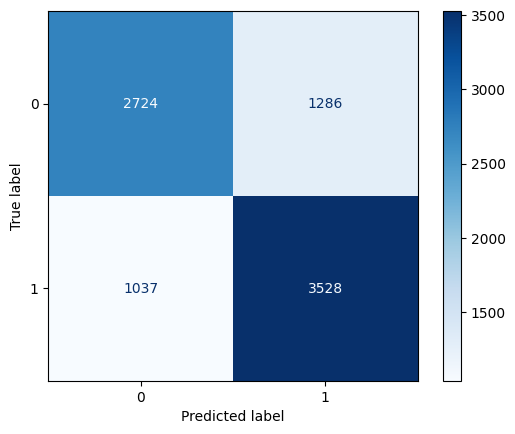

In [32]:
# compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(values_format='d', cmap='Blues')

In [33]:
# look at classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.72      0.68      0.70      4010
           1       0.73      0.77      0.75      4565

    accuracy                           0.73      8575
   macro avg       0.73      0.73      0.73      8575
weighted avg       0.73      0.73      0.73      8575

